<a href="https://colab.research.google.com/github/eyupdalan/BLM6114-hw1/blob/main/BLM6114hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install opencv-python
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.9/274.9 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.3/231.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.1/344.1 kB 25.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
    

In [4]:
import random
import torch
import pandas as pd
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from enum import Enum

## Verilerin alınması
https://huggingface.co/datasets/ytu-ce-cosmos/gsm8k_tr adresinde
bulunan dosyadaki question ları soru, answer ları cevap olarak kullanınız.
Bu dosyadan rasgele 1000 soru ve o sorunun cevabı 2’lisi seçiniz.

#### CSV'den okuma

In [5]:
#dataset = load_dataset("ytu-ce-cosmos/gsm8k_tr")
#all_data = dataset.to_pandas()

file_path = "/content/sample_data/gsm8k_tr.csv"
all_data = pd.read_csv(file_path)

print(all_data.head())

                                            question  \
0  Borris tekel bayisi her 6 ayda bir 90 kilogram...   
1  Mel, Katherine'den üç yaş küçük.  Katherine ik...   
2  James 2 ağacındaki tüm meyveleri toplar.  Her ...   
3  Kyle, her biri 15 origami yıldızı alabilen 2 c...   
4  Mark'ın iki evcil hayvanı var: Saniyede 10 adı...   

                                              answer  
0  Borris şu anda her 6 ayda 90 kilogram üzüm kul...  
1  Katherine iki düzine yaşına geldiğinde 24 yaşı...  
2                           James 24 ağaç dikmiştir.  
3  Kyle toplamda 5 cam şişe satın aldı (2 + 3). H...  
4  Kaplumbağanın yarışı berabere bitirmesi için 1...  


#### Rasgele 1000 datanın alınması

In [6]:
sample_count = 1000 #1000
total_data_length = len(all_data)
print("Total data length: ", total_data_length)

random.seed(111)
randomly_selected_indices = random.sample(range(total_data_length), sample_count) #randomly select 1000 samples

data = all_data.iloc[randomly_selected_indices].reset_index(drop=True)

print(data.head())


Total data length:  8792
                                            question  \
0  Bayan Thompson tanesi 3 dolardan 3 tavuk aldı....   
1  Bir bekleme odasında yirmi iki kişi bulunmakta...   
2  Elise babasının 250 kitaptan oluşan koleksiyon...   
3  Beyaz tavşan bir dakikada 15 metre zıplayabili...   
4  Grubun konserine 500 kişi katıldı. Bu konser i...   

                                              answer  
0                      Patatesler 6 dolara mal oldu.  
1                 Görüşme odasında dört kişi vardır.  
2  Elise'nin babasının 250 kitaplık koleksiyonund...  
3  Beyaz tavşanın 5 dakikada zıplayacağı mesafe: ...  
4  Her bilet 30$ ve grup bilet fiyatının %70'ini ...  


#### Seçilen modeller
https://huggingface.co/spaces/mteb/leaderboard adresinde ilk 100’e girmiş, multilingual olan ve 1 milyar parametreden küçük olan 5 model

#### Tokenizer işlemleri

In [7]:
selected_models = [
    "intfloat/multilingual-e5-large-instruct",
    "Lajavaness/bilingual-embedding-large",
    "HIT-TMG/KaLM-embedding-multilingual-mini-v1",
    "jinaai/jina-embeddings-v3",
    "BAAI/bge-m3"
]
compare_model = "ytu-ce-cosmos/turkish-colbert"
all_models = selected_models + [compare_model]

print("All models: ", all_models)

def average_pool(last_hidden_states: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

def create_model_embeddings(model_name, input_text, batch_size):
    embeddings_list = []

    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    model = AutoModel.from_pretrained(model_name, trust_remote_code=True)

    # Tek seferde embedding hesaplaması çok fazla memory tüketimine sebep olup
    # crash olmasına sebep oluyordu. o yüzden burada batch_size'a göre parçalı
    # parçalı hesaplanması sağlandı
    for i in range(0, len(input_text), batch_size):
        batch = input_text[i : i + batch_size]
        with torch.no_grad():
            batch_dict = tokenizer(batch, max_length=128, padding=True, truncation=True, return_tensors="pt")
            batch_dict = {k: v.to(model.device) for k, v in batch_dict.items()}
            outputs = model(**batch_dict)
        embeddings = average_pool(outputs.last_hidden_state, batch_dict["attention_mask"])
        embeddings = F.normalize(embeddings, p=2, dim=1)
        embeddings_list.append(embeddings)

    # Tüm embedding'leri birleştir
    return torch.cat(embeddings_list, dim=0)


All models:  ['intfloat/multilingual-e5-large-instruct', 'Lajavaness/bilingual-embedding-large', 'HIT-TMG/KaLM-embedding-multilingual-mini-v1', 'jinaai/jina-embeddings-v3', 'BAAI/bge-m3', 'ytu-ce-cosmos/turkish-colbert']


In [8]:
class Type(Enum):
  ANSWERS = "answers"
  QUESTIONS = "questions"

batch_size = 1024  # Her batch'te işlenecek metin sayısı

questions_text = data['question'].tolist()
answers_text = data['answer'].tolist()

model_embeddings_list = {}

for model_name in all_models:
    print(f"Model: {model_name}")

    question_embeddings = create_model_embeddings(model_name, questions_text, batch_size=batch_size)
    answer_embeddings = create_model_embeddings(model_name, answers_text, batch_size=batch_size)

    model_embeddings_list[model_name] = {
        Type.QUESTIONS: question_embeddings,
        Type.ANSWERS: answer_embeddings
    }
    print(f"{model_name} embedding created")

print("All embeddings created", model_embeddings_list)


Model: intfloat/multilingual-e5-large-instruct


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

intfloat/multilingual-e5-large-instruct embedding created
Model: Lajavaness/bilingual-embedding-large


tokenizer_config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

config.py:   0%|          | 0.00/7.12k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/dangvantuan/bilingual_impl:
- config.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling.py:   0%|          | 0.00/72.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/dangvantuan/bilingual_impl:
- modeling.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Lajavaness/bilingual-embedding-large embedding created
Model: HIT-TMG/KaLM-embedding-multilingual-mini-v1


tokenizer_config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

tokenization_qwen.py:   0%|          | 0.00/10.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/HIT-TMG/KaLM-embedding-multilingual-mini-v1:
- tokenization_qwen.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/370 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `eager`; unexpected results may be encountered.


HIT-TMG/KaLM-embedding-multilingual-mini-v1 embedding created
Model: jinaai/jina-embeddings-v3


tokenizer_config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

configuration_xlm_roberta.py:   0%|          | 0.00/6.54k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- configuration_xlm_roberta.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_lora.py:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

modeling_xlm_roberta.py:   0%|          | 0.00/51.1k [00:00<?, ?B/s]

mha.py:   0%|          | 0.00/34.4k [00:00<?, ?B/s]

rotary.py:   0%|          | 0.00/24.5k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- rotary.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- mha.py
- rotary.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


xlm_padding.py:   0%|          | 0.00/10.0k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- xlm_padding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


mlp.py:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- mlp.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


embedding.py:   0%|          | 0.00/3.88k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- embedding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


block.py:   0%|          | 0.00/17.8k [00:00<?, ?B/s]

stochastic_depth.py:   0%|          | 0.00/3.76k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- stochastic_depth.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- block.py
- stochastic_depth.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- modeling_xlm_roberta.py
- mha.py
- xlm_padding.py
- mlp.py
- embedding.py
- block.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was down

model.safetensors:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

jinaai/jina-embeddings-v3 embedding created
Model: BAAI/bge-m3


tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

BAAI/bge-m3 embedding created
Model: ytu-ce-cosmos/turkish-colbert


tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/263k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/766k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/646 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

ytu-ce-cosmos/turkish-colbert embedding created
All embeddings created {'intfloat/multilingual-e5-large-instruct': {<Type.QUESTIONS: 'questions'>: tensor([[ 0.0209,  0.0050, -0.0376,  ..., -0.0453, -0.0612,  0.0097],
        [ 0.0171,  0.0103, -0.0421,  ..., -0.0458, -0.0338,  0.0402],
        [ 0.0060,  0.0083, -0.0304,  ..., -0.0306, -0.0517,  0.0340],
        ...,
        [ 0.0230,  0.0041, -0.0480,  ..., -0.0193, -0.0522,  0.0265],
        [ 0.0069,  0.0024, -0.0320,  ..., -0.0592, -0.0515,  0.0153],
        [-0.0060,  0.0166, -0.0378,  ..., -0.0472, -0.0371,  0.0280]]), <Type.ANSWERS: 'answers'>: tensor([[ 0.0208,  0.0143,  0.0043,  ..., -0.0237, -0.0274,  0.0255],
        [ 0.0321,  0.0276, -0.0135,  ..., -0.0354, -0.0332,  0.0268],
        [ 0.0321,  0.0085, -0.0171,  ..., -0.0303, -0.0581,  0.0394],
        ...,
        [-0.0066,  0.0149, -0.0326,  ..., -0.0219, -0.0482,  0.0353],
        [ 0.0032, -0.0170, -0.0224,  ..., -0.0149, -0.0478,  0.0076],
        [ 0.0061,  0.0196, -

#### Arama ve top1 top5 baraşarılarını hesaplama fonksiyonları

In [9]:
def find_most_similar_indices(type: Type, embeddings: torch.Tensor, query_idx: int, top_k: int = 5):
    query = embeddings[type][query_idx].unsqueeze(0)
    context_embedding_type = Type.ANSWERS if type == Type.QUESTIONS else Type.QUESTIONS
    context_embeddings = embeddings[context_embedding_type]
    similarity = F.cosine_similarity(query, context_embeddings, dim=1)

    top_k_values, top_k_indices = torch.topk(similarity, top_k)
    # Tensor'ları Python listesine dönüştür
    top_k_indices = top_k_indices.tolist()

    # Sadece top_k sonucu al
    top_k_scores = [similarity[idx].item() for idx in top_k_indices]

    return top_k_indices, top_k_scores

def search_from_embedding(type: Type, embeddings: torch.Tensor, query_idx: int, top_k: int = 5):
    top_k_indices, top_k_scores = find_most_similar_indices(type, embeddings, query_idx, top_k)

    if(type == Type.ANSWERS):
      top_k_results = [questions_text[idx] for idx in top_k_indices]
    else:
      top_k_results = [answers_text[idx] for idx in top_k_indices]

    #print(f"Sorgu: {answers_text[query_idx]}")
    #for i, (result, score) in enumerate(zip(top_k_results, top_k_scores)):
    #    print(f"{i+1}. Benzerlik: {score:.4f}, Metin: {result}")

    return top_k_results, top_k_scores, top_k_indices

def calculate_accuracy(type: Type, embeddings: torch.Tensor, top_k: int = 5):
    total_correct = 0
    total_queries = len(data)

    for query_idx in range(total_queries):
        top_k_results, top_k_scores, top_k_indices = search_from_embedding(type,embeddings, query_idx, top_k)

        # sorunun index'i ile doğru cevabının index'i aynı
        if(query_idx in top_k_indices):
            total_correct += 1

    accuracy = total_correct / total_queries
    return accuracy

#

#### Top-5 ve top-1 sonuçları için grafik çizimi

In [31]:
def draw_results(model_results):
  fig, ax = plt.subplots(figsize=(10, 6))  # Create a figure and axes object
  bars = ax.bar(model_results["models"], model_results["accuracy"], color='skyblue')  # Create the bars and store them
  ax.bar_label(bars, fmt='%.3f', label_type='edge')  # Add labels to the bars with 3 decimal places, positioned at the edge
  ax.set_title('Sonuçlar')  # Grafik başlığını ekle
  ax.set_xlabel('Modeller')  # X eksenini etiketle
  ax.set_ylabel('Başarı')  # Y eksenini etiketle
  ax.set_ylim(0, 1)  # Y ekseninin sınırlarını ayarla
  plt.xticks(rotation=45, ha='right')  # X ekseni etiketlerini döndür
  fig.tight_layout()  # Grafik düzenini iyileştir
  plt.show()  # Grafiği göster


#### Cevaplar için top-5 sonuçları

Model: intfloat/multilingual-e5-large-instruct, accuracy: 0.899
Model: Lajavaness/bilingual-embedding-large, accuracy: 0.989
Model: HIT-TMG/KaLM-embedding-multilingual-mini-v1, accuracy: 0.945
Model: jinaai/jina-embeddings-v3, accuracy: 0.992
Model: BAAI/bge-m3, accuracy: 0.962
Model: ytu-ce-cosmos/turkish-colbert, accuracy: 0.94


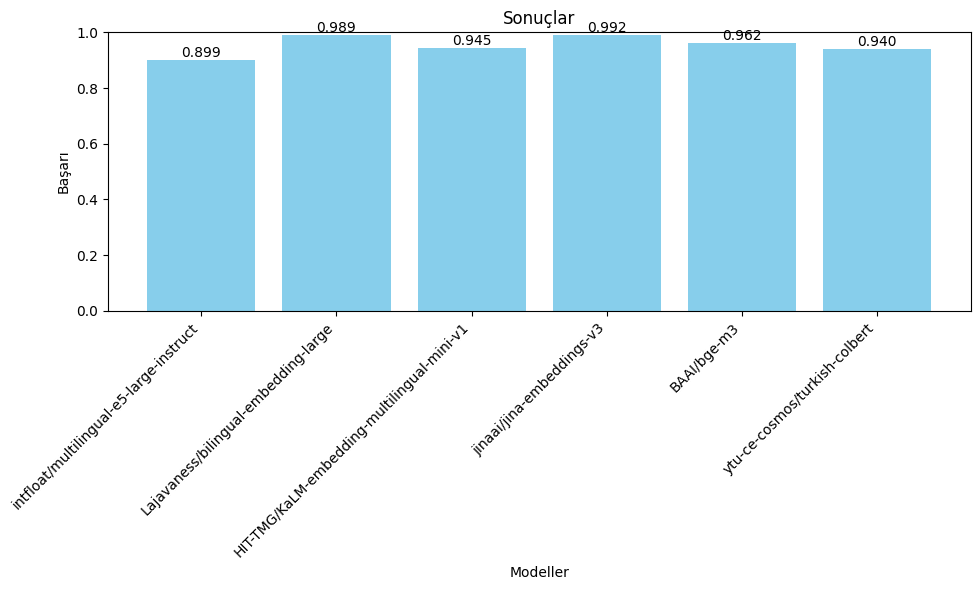

In [32]:
model_top_5_results = {"models": [], "accuracy": []} # Initialize with empty lists
for model_name in all_models:
  embeddings = model_embeddings_list[model_name]
  accuracy = calculate_accuracy(Type.QUESTIONS, embeddings, 5)
  model_top_5_results["models"].append(model_name)
  model_top_5_results["accuracy"].append(accuracy)
  print(f"Model: {model_name}, accuracy: {accuracy}")

draw_results(model_top_5_results)


#### Cevaplar için top-1 sonuçları

Model: intfloat/multilingual-e5-large-instruct, accuracy: 0.872
Model: Lajavaness/bilingual-embedding-large, accuracy: 0.977
Model: HIT-TMG/KaLM-embedding-multilingual-mini-v1, accuracy: 0.904
Model: jinaai/jina-embeddings-v3, accuracy: 0.971
Model: BAAI/bge-m3, accuracy: 0.933
Model: ytu-ce-cosmos/turkish-colbert, accuracy: 0.84


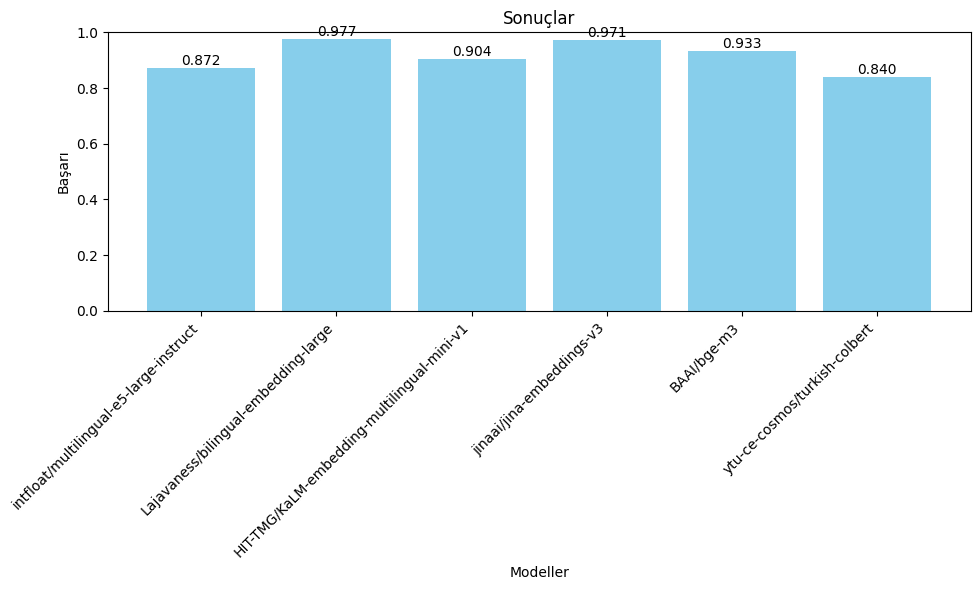

In [33]:
model_top_1_results = {"models": [], "accuracy": []} # Initialize with empty lists

for model_name in all_models:
  embeddings = model_embeddings_list[model_name]
  accuracy = calculate_accuracy(Type.QUESTIONS, embeddings, 1)
  model_top_1_results["models"].append(model_name)
  model_top_1_results["accuracy"].append(accuracy)
  print(f"Model: {model_name}, accuracy: {accuracy}")

draw_results(model_top_1_results)

#### Sorular için top-5 sonuçları

Model: intfloat/multilingual-e5-large-instruct, accuracy: 0.994
Model: Lajavaness/bilingual-embedding-large, accuracy: 0.995
Model: HIT-TMG/KaLM-embedding-multilingual-mini-v1, accuracy: 0.98
Model: jinaai/jina-embeddings-v3, accuracy: 0.996
Model: BAAI/bge-m3, accuracy: 0.991
Model: ytu-ce-cosmos/turkish-colbert, accuracy: 0.951


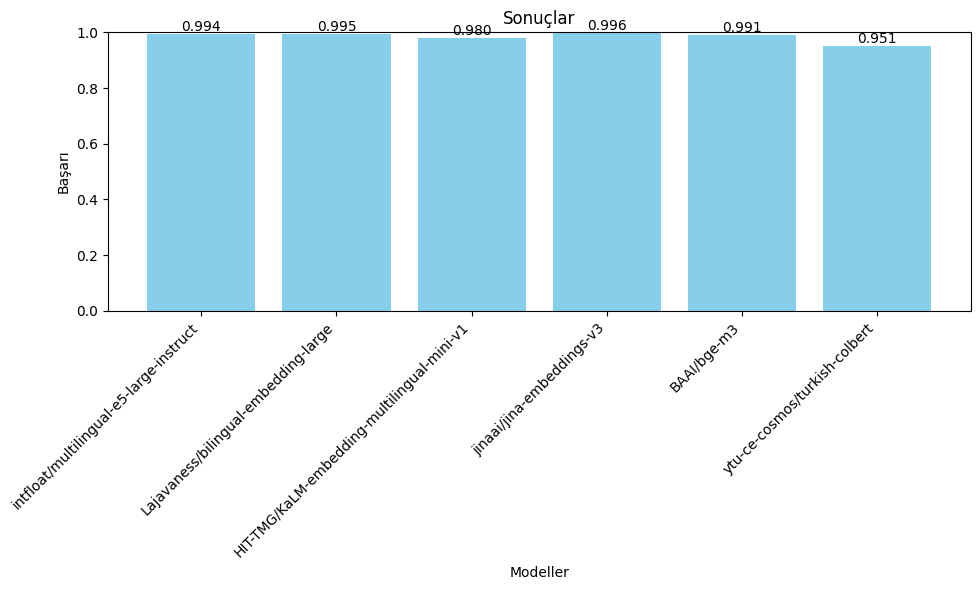

In [34]:
model_top_5_results = {"models": [], "accuracy": []} # Initialize with empty lists

for model_name in all_models:
  embeddings = model_embeddings_list[model_name]
  accuracy = calculate_accuracy(Type.ANSWERS, embeddings, 5)
  model_top_5_results["models"].append(model_name)
  model_top_5_results["accuracy"].append(accuracy)
  print(f"Model: {model_name}, accuracy: {accuracy}")

draw_results(model_top_5_results)


#### Sorular için top-1 sonuçları

Model: intfloat/multilingual-e5-large-instruct, accuracy: 0.976
Model: Lajavaness/bilingual-embedding-large, accuracy: 0.984
Model: HIT-TMG/KaLM-embedding-multilingual-mini-v1, accuracy: 0.947
Model: jinaai/jina-embeddings-v3, accuracy: 0.978
Model: BAAI/bge-m3, accuracy: 0.966
Model: ytu-ce-cosmos/turkish-colbert, accuracy: 0.852


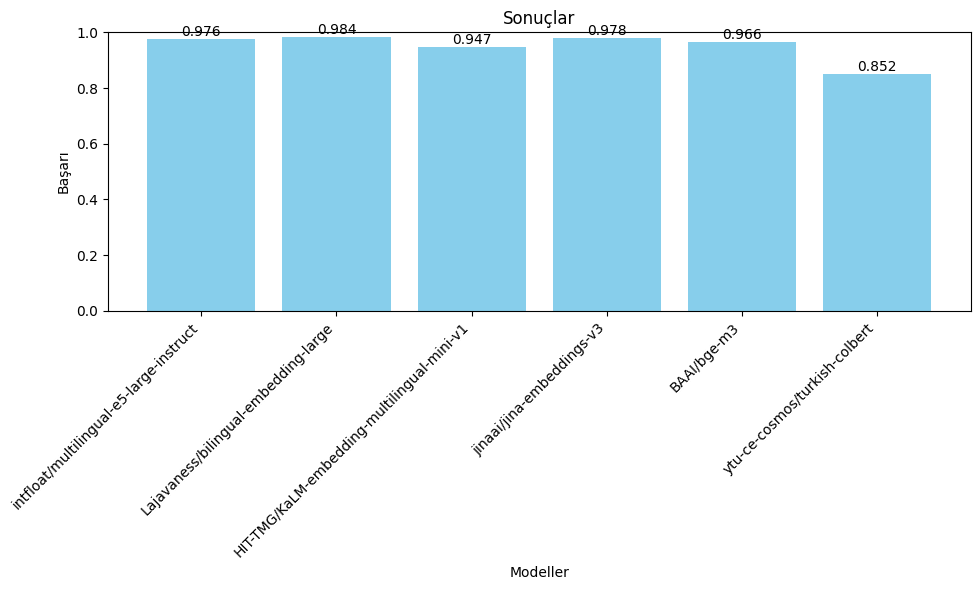

In [35]:
model_top_1_results = {"models": [], "accuracy": []} # Initialize with empty lists

for model_name in all_models:
  embeddings = model_embeddings_list[model_name]
  accuracy = calculate_accuracy(Type.ANSWERS, embeddings, 1)
  model_top_1_results["models"].append(model_name)
  model_top_1_results["accuracy"].append(accuracy)
  print(f"Model: {model_name}, accuracy: {accuracy}")

draw_results(model_top_1_results)


#### t-SNA

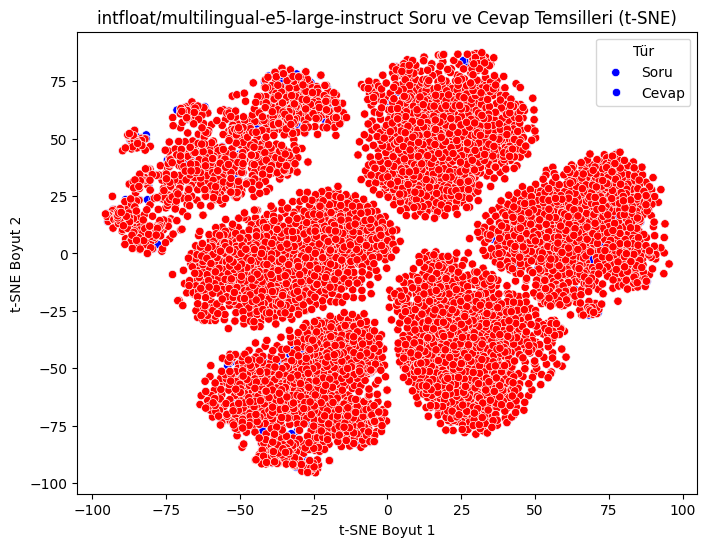

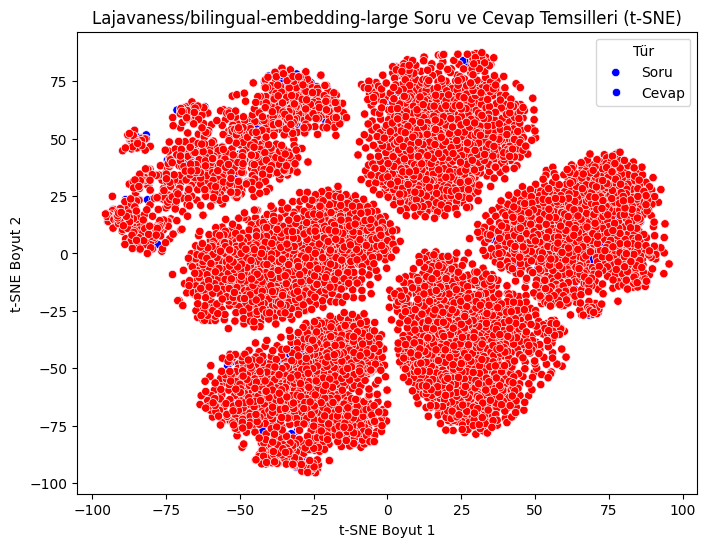

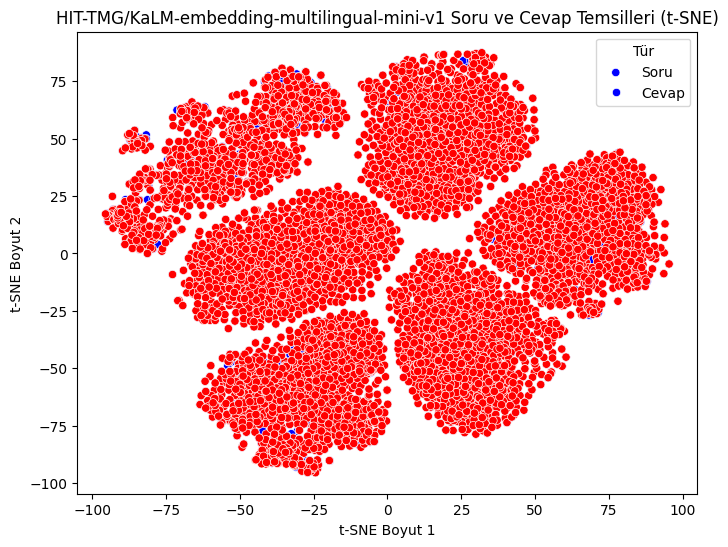

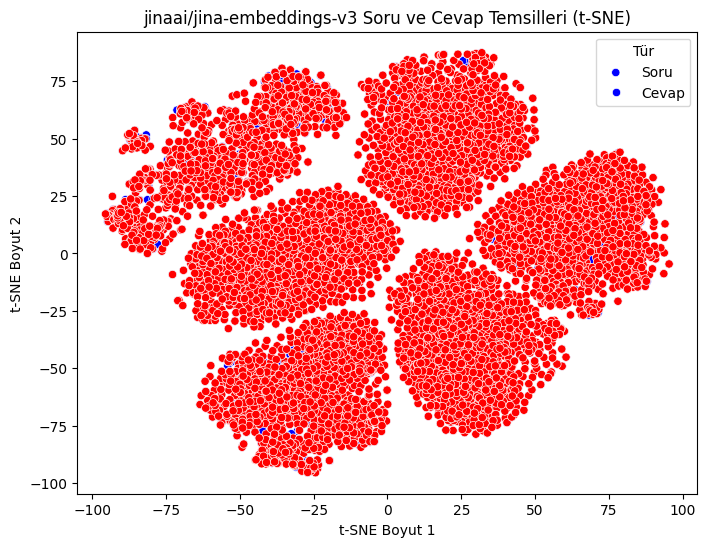

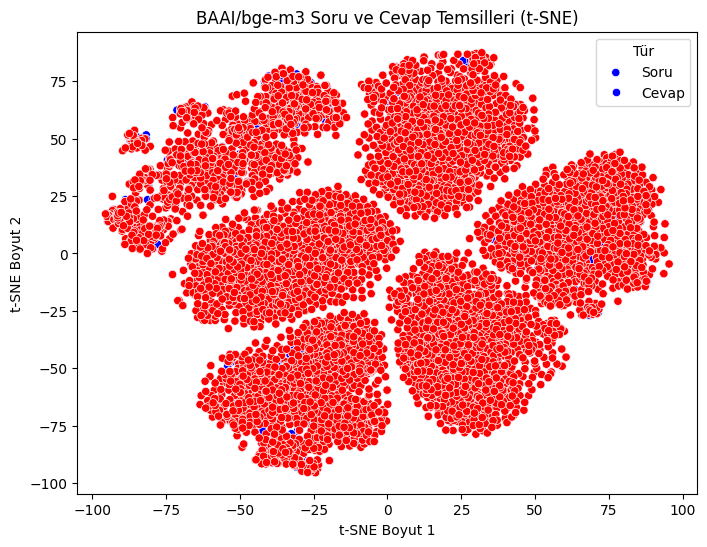

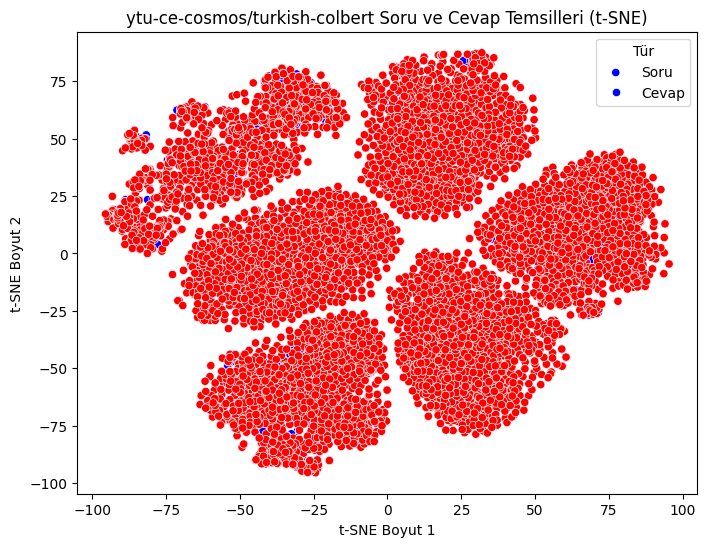

In [14]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

all_embeddings = []
labels = []

# Determine the minimum embedding dimension across all models
min_dim = float('inf')  # Initialize with infinity
for model_name, embeddings in model_embeddings_list.items():
  min_dim = min(min_dim, embeddings[Type.QUESTIONS].shape[1], embeddings[Type.ANSWERS].shape[1])

# Now process embeddings, ensuring consistent dimensions
for model_name, embeddings in model_embeddings_list.items():
  # Convert embeddings to numpy arrays and ensure they have the same number of dimensions
  question_embeddings_np = embeddings[Type.QUESTIONS].cpu().numpy()[:, :min_dim] # Resize here
  answer_embeddings_np = embeddings[Type.ANSWERS].cpu().numpy()[:, :min_dim] # Resize here

  all_embeddings.extend(question_embeddings_np)
  all_embeddings.extend(answer_embeddings_np)
  labels.extend([0] * len(embeddings[Type.QUESTIONS]))
  labels.extend([1] * len(embeddings[Type.ANSWERS]))

# Convert all_embeddings list to a NumPy array
all_embeddings = np.array(all_embeddings)

labels = np.array(labels)

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings)

df = pd.DataFrame(data={'x': embeddings_2d[:, 0], 'y': embeddings_2d[:, 1], 'label': labels})

# Her model için ayrı bir grafik oluşturun
for model_name in all_models:
  plt.figure(figsize=(8, 6))
  sns.scatterplot(x='x', y='y', hue='label', data=df, palette=['blue', 'red'])
  plt.title(f'{model_name} Soru ve Cevap Temsilleri (t-SNE)')
  plt.xlabel('t-SNE Boyut 1')
  plt.ylabel('t-SNE Boyut 2')
  plt.legend(title='Tür', labels=['Soru', 'Cevap'])
  plt.show()